In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.singles_pairs.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()

def reset_bg():
    vis['/Background'].set_property("top_color", [0.2, 0.2, 0.2])
    vis['/Background'].set_property("bottom_color", [.32, .32, .35])

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/
Meshcat url:  http://127.0.0.1:7007/static/


In [13]:
# Draw a random sample from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)
torch.random.manual_seed(1)
tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()
print("Sampled scene with %d objects and %d pairs." % 
      (len(tree.find_nodes_by_type(Object)),
       len(tree.find_nodes_by_type(Pair))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.05, with_triad=False)
reset_bg()

Sampled scene with 5 objects and 2 pairs.
Sampled tree has score -6.616071


Super tree has 15 nodes


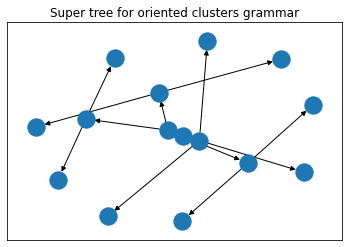

In [4]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

In [14]:
# Parse this scene.
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=False, max_scene_extent_in_any_dir=10., N_solutions=10
)

In [15]:
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
draw_scene_tree_structure_meshcat(mip_optimized_trees[0], zmq_url=vis.window.zmq_url, prefix="mip_scene_tree", with_triad=False, node_sphere_size=0.05)

for node in mip_optimized_trees[0]:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

Avg elementwise deviation from R^T R = I:  tensor(9.5603e-17)
Avg elementwise deviation from R^T R = I:  tensor(9.5603e-17)
Avg elementwise deviation from R^T R = I:  tensor(9.5603e-17)
Avg elementwise deviation from R^T R = I:  tensor(5.9574e-07)
Avg elementwise deviation from R^T R = I:  tensor(0.0683)
Avg elementwise deviation from R^T R = I:  tensor(0.0292)
Avg elementwise deviation from R^T R = I:  tensor(6.5813e-07)
Avg elementwise deviation from R^T R = I:  tensor(3.5639e-07)
Avg elementwise deviation from R^T R = I:  tensor(2.1588e-16)
Avg elementwise deviation from R^T R = I:  tensor(9.4061e-17)


In [18]:
# Do NLP refinement of top trees
refined_trees = []
for k, mip_optimized_tree in enumerate(mip_optimized_trees):
    refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=False)
    refined_trees.append(refinement_results.refined_tree)
    draw_scene_tree_structure_meshcat(refined_tree, zmq_url=vis.window.zmq_url, prefix="topNrefined/%d" % k, node_sphere_size=0.05, with_triad=False)
    
draw_scene_tree_structure_meshcat(refined_trees[0], zmq_url=vis.window.zmq_url, prefix="refined_scene_tree", node_sphere_size=0.05, with_triad=False)

reset_bg()